In [3]:
import numpy as np
import pyemma as pe
import itertools
import mdtraj as md
import matplotlib.pyplot as plt
from __future__ import print_function
import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from glob import glob
import os
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
def make_stacking_angles(sub_atoms, lig_atoms):
    def stacking_angles(xtc):
        coms = np.empty((xtc.n_frames, 2, 3))
        normals = np.empty((xtc.n_frames, 2, 3))
        for i, atoms in enumerate((sub_atoms, lig_atoms)):
            # Center-of-mass for each aromatic system
            coms[:, i] = md.compute_center_of_mass(xtc.atom_slice(atoms))

            # Create a and b vectors in the aromatic plane to compute the normals
            com_o_r = np.empty((xtc.n_frames, 2, 3))
            for j in range(2):
                other = xtc.atom_slice(atoms).xyz[:, j]
                com_o_r[:, j] = other - coms[:, i]
                com_o_r[:, j] /= np.linalg.norm(com_o_r[:, j], axis=1, keepdims=True)
            normals[:, i] = (np.cross(com_o_r[:, 0], com_o_r[:, 1]) /
                             np.sqrt(1 - com_o_r.prod(axis=1).sum(axis=-1) ** 2).reshape(-1, 1))

        # Distance between both aromatic COMs
        com_r = np.diff(coms, axis=1)

        # alpha (substrate aromatic angle to COM-distance) and
        # beta (ligand aromatic angle to COM-distance)
        angles = np.arccos((com_r * normals).sum(axis=-1) /
                         (np.linalg.norm(com_r, axis=-1) *
                          np.linalg.norm(normals, axis=-1)))
        
        # COM distances
        comds = np.sqrt((com_r.squeeze() ** 2).sum(axis=-1)).reshape(-1, 1)

        return np.hstack((angles.astype(np.float32), comds.astype(np.float32)))
    return stacking_angles

In [5]:
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

In [6]:
c_AB = (0.7686, 0.4196, 0.1882, 1)   #set color for AB points
e_AB = (0.7686, 0.4196, 0.1882, 0.5) #set color for AB errors
c_G5 = (0.3725, 0.5804, 0.4588, 1)   #set color for AB+10074-G5 points
e_G5 = (0.3725, 0.5804, 0.4588, 0.5) #set color for AB+10074-G5 errors
blue_dark  = (0.4392, 0.5961, 0.8196) #set dark blue
blue_light = (0.6549, 0.7765, 0.8941) #set light blue
red_dark   = (0.4431, 0.1059, 0.0941) #set dark red
red_light  = (0.6392, 0.4118, 0.3882) #set light red

In [7]:
sim_names = ('ligandA',"ligandB", "ligandC","ligandD","ab_apo","ab_G5")
    
top, trajs = {}, {}
#trajs = {k: sorted(glob("/pool/work/adelie/results_G5_der/input_data/trajectories/{0}/*_traj.xtc".format(k))) for k in sim_names}
trajs={k: "/pool/work/adelie/results_G5_der/input_data/trajectories/{0}_traj.xtc".format(k) for k in sim_names}
#top = {k: "/pool/work/adelie/results_G5_der/input_data/topology/{0}/*.gro".format(k) for k in sim_names}
top = {k: "/pool/work/adelie/results_G5_der/input_data/topology/{0}.gro".format(k) for k in sim_names}
weight={k: "/pool/work/adelie/results_G5_der/input_data/weights/{0}_weights".format(k) for k in sim_names}


topo = md.load_topology("/pool/work/adelie/results_control/input_data/ab_apo.gro")


In [8]:
n_atoms = {k: md.load_topology(top[k]).n_atoms for k in sim_names}

In [9]:
#Abeta contstant residues - those that will produce aromatic stacking
resids = (3, 9, 18, 19) # PHE4, TYR10, PHE19, PHE20

#ligand Aromatic residues - ''
lig_arom_atoms = dict(
    ligandB=dict(
        nbf=np.array([634, 633, 632, 631, 630, 629, 628, 636, 635]),  # Nitrobenzofurazan
        a1=np.array([642, 641, 640, 639, 638, 637]),  # Center phenyl
        a2=np.array([647, 646, 645, 644, 643, 648]),  # Ortho phenyl
    ),
    ligandA=dict(
        nbf=np.array([633, 634, 638, 639, 628, 629, 632, 631, 630]),  # Nitrobenzofurazan
        a1=np.array([645, 644, 643, 642, 641, 640]),  # Center phenyl
    ),
    ligandD=dict(
        nbf=np.array([630, 631, 632, 633, 628, 629]),  # Phenylamine
        a1=np.array([638, 637, 636, 635, 634, 639]),  # 'Center' phenyl
    ),
    ligandE=dict(
        nbf=np.array([631, 632, 630, 629, 633, 634,638,639,628]),  # Nitrobenzofurazan
    )
)


## LigandB

In [10]:
k = "ligandB"
angles = {}
for arom_res in resids:
    angles[arom_res] = {}
    res_name = topo.residue(arom_res)
    sub_arom_atoms = topo.select(f"resid {arom_res} and (name CG or name CD1 or name CD2 or name CE1 or name CE2 or name CZ)")
    for name, frag in lig_arom_atoms[k].items():
        stacking = make_stacking_angles(sub_arom_atoms, frag)
        feat = pe.coordinates.featurizer(top[k])
        feat.add_custom_func(stacking, dim=3)
        inp = pe.coordinates.source(trajs[k], feat)
        angles[arom_res][name] = np.vstack(inp.get_output())
        
k = "ligandB"
n_bins = 50
mats = {}
for resid in angles.keys():
    mats[resid] = {}
    for arom_res in angles[resid].keys():
        ang = angles[resid][arom_res]
        inter = ang[:, 2] < 0.6
        count = np.count_nonzero(inter)

5
12
0
279
642
724
248
1329
254
63
1004
778


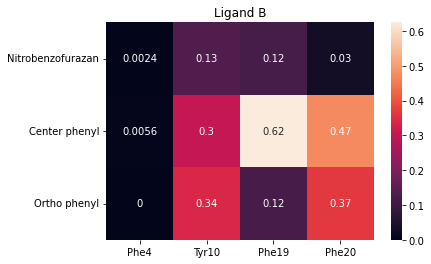

In [37]:
array=[count]
y=normalize_2d(array)
x_axis_labels = ['Phe4','Tyr10','Phe19', 'Phe20'] # labels for x-axis
y_axis_labels = ['Nitrobenzofurazan','Center phenyl','Ortho phenyl'] # labels for y-axis
ax = sns.heatmap(y,annot=True,xticklabels=x_axis_labels,yticklabels=y_axis_labels,)
ax.set_title('Ligand B')

In [ ]:
# ... rinse & repeat for each other ligand